In [1]:
# Essential imports for data parsing analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
import warnings
warnings.filterwarnings('ignore')
import cmc_parser as cp

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import hdbscan


# Individual file parsing

In [2]:
def parse_bhformation_dat(model_path):

    filepath= model_path+'/initial.bhformation.dat'
    # Define column names for the core data we want to keep
    column_names = [
        'time', 'r', 'binary', 'ID', 'zams_m', 'm_progenitor', 'bh_mass',
        'bh_spin', 'birth_kick'
    ]

    # Read the file, skipping any lines that start with #
    data = []
    with open(filepath, 'r') as file:
        for line in file:
            if not line.startswith('#'):
                # Split the line by whitespace
                values = line.strip().split()
                if len(values) >= 9:  # Ensure we have enough values for our columns
                    # Only take the first 9 values (excluding vs columns)
                    data.append(values[:9])

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=column_names)

    # Convert columns to appropriate data types
    numeric_cols = ['time', 'r', 'zams_m', 'm_progenitor', 'bh_mass', 'bh_spin']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])

    # Convert binary and ID to integers
    df['binary'] = df['binary'].astype(int)
    df['ID'] = df['ID'].astype(int)

    # Handle birth_kick column
    df['birth_kick'] = pd.to_numeric(df['birth_kick'], errors='coerce')

    return df
parse_bhformation_dat('data/N2.0rv0.5rg2.0Z0.0002')

,time,r,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick
0,0.009197,0.190420,1,124149,0.000000,47.24320,42.51890,0,0.0000
1,0.009476,0.784866,0,178115,104.318000,101.11100,40.50000,0,1.0000
2,0.009920,0.069105,1,150155,0.000000,37.76810,33.99130,0,0.0000
3,0.010120,0.109359,1,228329,0.000000,35.36190,31.82570,0,0.0000
4,0.010364,1.755900,0,9114,0.181263,32.65030,29.38530,0,1.0000
...,...,...,...,...,...,...,...,...,...
338,0.039135,0.127507,1,216993,0.000000,75.53730,67.98360,0,0.0000
339,0.040909,0.233458,0,185677,0.178679,25.05900,9.83723,0,151.7321
340,0.043852,0.321977,0,238752,0.336246,21.79050,19.61150,0,1.0000
341,6.507828,0.035967,1,0,0.000000,4.23882,16.73940,0,0.0000


In [3]:
# def parse_collision_log(model_path):

#     filepath= model_path +'/initial.collision.log'
#     data = {
#         'time': [],
#         'collision_type': [],
#         'idm': [],
#         'mm': [],
#         'id1': [],
#         'm1': [],
#         'id2': [],
#         'm2': [],
#         'r': [],
#         'typem': [],
#         'type1': [],
#         'type2': []
#     }

#     with open(filepath, 'r') as file:
#         for line in file:
#             if line.startswith('t='):
#                 # Extract time
#                 time_match = re.search(r't=([\d.eE+-]+)', line)
#                 # Extract collision type (binary-single, binary-binary, single-single)
#                 type_match = re.search(r'\s(binary-[a-z]+|single-single)\s', line) 
#                 # Extract idm and mm
#                 idm_mm_match = re.search(r'idm=(\d+)\(mm=([\d.eE+-]+)\)', line)
#                 # Extract id1 and m1
#                 id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
#                 # Extract id2 and m2
#                 id2_m2_match = re.search(r'id2=(\d+)\(m2=([\d.eE+-]+)\)', line)
#                 # Extract r
#                 r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
#                 # Extract typem, type1, type2
#                 typem_match = re.search(r'typem=(\d+)', line)
#                 type1_match = re.search(r'type1=(\d+)', line)
#                 type2_match = re.search(r'type2=(\d+)', line)

#                 if all([time_match, type_match, idm_mm_match, id1_m1_match, id2_m2_match, r_match, typem_match, type1_match, type2_match]):
#                     data['time'].append(float(time_match.group(1)))
#                     data['collision_type'].append(type_match.group(1))
#                     data['idm'].append(int(idm_mm_match.group(1)))
#                     data['mm'].append(float(idm_mm_match.group(2)))
#                     data['id1'].append(int(id1_m1_match.group(1)))
#                     data['m1'].append(float(id1_m1_match.group(2)))
#                     data['id2'].append(int(id2_m2_match.group(1)))
#                     data['m2'].append(float(id2_m2_match.group(2)))
#                     data['r'].append(float(r_match.group(1)))
#                     data['typem'].append(int(typem_match.group(1)))
#                     data['type1'].append(int(type1_match.group(1)))
#                     data['type2'].append(int(type2_match.group(1)))

#     df = pd.DataFrame(data)
#     return df
# parse_collision_log('data/N2.0rv0.5rg2.0Z0.0002')

In [4]:
def parse_collision_log(model_path):

    filepath = model_path + '/initial.collision.log'
    data = {
        'time': [],
        'collision_type': [],
        'idm': [],
        'mm': [],
        'id1': [],
        'm1': [],
        'id2': [],
        'm2': [],
        'r': [],
        'typem': [],
        'type1': [],
        'type2': []
    }
    
    def add_collision_record(time, collision_type, idm, mm, id1, m1, id2, m2, r, typem, type1, type2):
        data['time'].append(time)
        data['collision_type'].append(collision_type)
        data['idm'].append(idm)
        data['mm'].append(mm)
        data['id1'].append(id1)
        data['m1'].append(m1)
        data['id2'].append(id2)
        data['m2'].append(m2)
        data['r'].append(r)
        data['typem'].append(typem)
        data['type1'].append(type1)
        data['type2'].append(type2)
    
    with open(filepath, 'r') as file:
        for line in file:
            if line.startswith('t='):
                # Extract common fields
                time_match = re.search(r't=([\d.eE+-]+)', line)
                type_match = re.search(r'\s(binary-[a-z]+|single-single)\s', line)
                idm_mm_match = re.search(r'idm=(\d+)\(mm=([\d.eE+-]+)\)', line)
                r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
                typem_match = re.search(r'typem=(\d+)', line)
                
                # Extract id1, m1, id2, m2
                id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
                id2_m2_match = re.search(r'id2=(\d+)\(m2=([\d.eE+-]+)\)', line)
                type1_match = re.search(r'type1=(\d+)', line)
                type2_match = re.search(r'type2=(\d+)', line)
                
                # Check for 3-body collision
                id3_m3_match = re.search(r'id3=(\d+)\(m3=([\d.eE+-]+)\)', line)
                type3_match = re.search(r'type3=(\d+)', line)
                
                #  minimum required fields
                if not all([time_match, type_match, idm_mm_match, id1_m1_match, id2_m2_match, r_match, typem_match, type1_match, type2_match]):
                    continue
                
                # Extract common values
                time = float(time_match.group(1))
                original_idm = int(idm_mm_match.group(1))
                original_mm = float(idm_mm_match.group(2))
                r = float(r_match.group(1))
                typem = int(typem_match.group(1))
                
                if not (id3_m3_match and type3_match):
                    add_collision_record(
                        time=time,
                        collision_type=type_match.group(1),
                        idm=original_idm,
                        mm=original_mm,
                        id1=int(id1_m1_match.group(1)),
                        m1=float(id1_m1_match.group(2)),
                        id2=int(id2_m2_match.group(1)),
                        m2=float(id2_m2_match.group(2)),
                        r=r,
                        typem=typem,
                        type1=int(type1_match.group(1)),
                        type2=int(type2_match.group(1))
                    )
                
                # Handle 3-body collision 
                else:
                    
                    objects = [
                        (int(id1_m1_match.group(1)), float(id1_m1_match.group(2)), int(type1_match.group(1))),
                        (int(id2_m2_match.group(1)), float(id2_m2_match.group(2)), int(type2_match.group(1))),
                        (int(id3_m3_match.group(1)), float(id3_m3_match.group(2)), int(type3_match.group(1)))
                    ]
                    
                
                    objects.sort(key=lambda x: x[1], reverse=True)
                    
                    # Collision 1: largest mass + second largest mass
                    largest_id, largest_mass, largest_type = objects[0]
                    second_id, second_mass, second_type = objects[1]
                    smallest_id, smallest_mass, smallest_type = objects[2]
                    
                    collision1_idm = largest_id + second_id
                    collision1_mm = largest_mass + second_mass


                    add_collision_record(
                        time=time,
                        collision_type=type_match.group(1),
                        idm=collision1_idm,
                        mm=collision1_mm,
                        id1=largest_id,
                        m1=largest_mass,
                        id2=second_id,
                        m2=second_mass,
                        r=r,
                        typem=typem,
                        type1=largest_type,
                        type2=second_type
                    )
                    
                    # Collision 2: collision 1 product + smallest mass
                    add_collision_record(
                        time=time,
                        collision_type=type_match.group(1),
                        idm=original_idm,
                        mm=original_mm,
                        id1=collision1_idm,
                        m1=collision1_mm,
                        id2=smallest_id,
                        m2=smallest_mass,
                        r=r,
                        typem=typem,
                        type1=typem,  # Assuming the merged object also gets typem from the orginal col
                        type2=smallest_type
                    )
    
    df = pd.DataFrame(data)
    return df


In [5]:
def parse_merger_file(model_path):
    filepath = model_path + '/initial.semergedisrupt.log'
    # Initialize lists to store the extracted data
    data = {
        'time': [],
        'interaction_type': [],
        'id_rem': [],
        'mass_rem': [],
        'id1': [],
        'm1': [],
        'id2': [],
        'm2': [],
        'r': [],
        'type_rem': [],
        'type1': [],
        'type2': []
    }

    with open(filepath, 'r') as file:
        for line in file:
            # Skip comment lines
            if line.startswith('#'):
                continue

            # Check if this is a data line
            if line.startswith('t='):
                # Extract time
                time_match = re.search(r't=([0-9.eE+-]+)', line)
                time = float(time_match.group(1)) if time_match else np.nan

                # Extract interaction type
                type_match = re.search(r't=[\d.eE+-]+\s+(\w+)', line)
                interaction_type = type_match.group(1) if type_match else np.nan

                # Extract remnant ID and mass
                id_rem_match = re.search(r'idr=(\d+)\(mr=([\d.eE+-]+)\)', line)
                id_rem = int(id_rem_match.group(1)) if id_rem_match else np.nan
                mass_rem = float(id_rem_match.group(2)) if id_rem_match else np.nan

                # Extract id1 and m1
                id1_m1_match = re.search(r'id1=(\d+)\(m1=([\d.eE+-]+)\)', line)
                id1 = int(id1_m1_match.group(1)) if id1_m1_match else np.nan
                m1 = float(id1_m1_match.group(2)) if id1_m1_match else np.nan

                # Extract id2 and m2
                id2_m2_match = re.search(r'id2=(\d+)\(m2=([\d.eE+-]+)\)', line)
                id2 = int(id2_m2_match.group(1)) if id2_m2_match else np.nan
                m2 = float(id2_m2_match.group(2)) if id2_m2_match else np.nan

                # Extract radius
                r_match = re.search(r'\(r=([\d.eE+-]+)\)', line)
                r = float(r_match.group(1)) if r_match else np.nan

                # Extract types
                type_rem_match = re.search(r'typer=(\d+)', line)
                type1_match = re.search(r'type1=(\d+)', line)
                type2_match = re.search(r'type2=(\d+)', line)

                type_rem = int(type_rem_match.group(1)) if type_rem_match else np.nan
                type1 = int(type1_match.group(1)) if type1_match else np.nan
                type2 = int(type2_match.group(1)) if type2_match else np.nan

                # Append data
                data['time'].append(time)
                data['interaction_type'].append(interaction_type)
                data['id_rem'].append(id_rem)
                data['mass_rem'].append(mass_rem)
                data['id1'].append(id1)
                data['m1'].append(m1)
                data['id2'].append(id2)
                data['m2'].append(m2)
                data['r'].append(r)
                data['type_rem'].append(type_rem)
                data['type1'].append(type1)
                data['type2'].append(type2)

    # Create DataFrame
    df = pd.DataFrame(data)
    return df

# Usage
merger_df = parse_merger_file('data/N2.0rv0.5rg2.0Z0.0002')

merger_df


,time,interaction_type,id_rem,mass_rem,id1,m1,id2,m2,r,type_rem,type1,type2
0,0.001989,disrupt1,312311.0,75.21870,312311,74.964600,162670,0.254204,0.314027,1.0,1,0
1,0.005335,disrupt1,136651.0,89.76560,136651,89.665800,125486,0.099913,0.221251,1.0,1,0
2,0.005919,disrupt1,161709.0,83.86030,161709,78.209600,204653,5.650770,0.063689,1.0,1,1
3,0.007645,disrupt1,325918.0,78.02040,325918,77.910400,158314,0.110015,0.062531,1.0,1,0
4,0.008486,disrupt2,175727.0,109.86200,161895,0.092841,175727,109.886000,0.181820,2.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
618,9.037510,disruptboth,NaN,NaN,210009,1.664140,160681,1.102050,0.012559,NaN,8,1
619,9.157400,disrupt2,287355.0,2.35583,155861,0.980142,287355,1.870000,0.017850,5.0,11,6
620,9.162860,disrupt2,378095.0,2.80844,162500,0.876363,378095,2.070240,0.008220,4.0,11,5
621,9.181540,disruptboth,NaN,NaN,219323,1.107870,125797,1.202410,0.011862,NaN,5,11


# Unit Conversion

In [6]:
def load_conversion_factors(model_path):

    
    conv_file_path = os.path.join(model_path, 'initial.conv.sh')

    # Load conversion factors using cmc_parser - exactly as you showed
    conv_file = cp.conversion_file(conv_file_path)
        
    # Extract the conversion factors you demonstrated
    conversion_factors = {
        'mass_msun_mstar': conv_file.mass_msun_mstar,  # For converting masses
        'time_myr': conv_file.time_myr,                # For converting times 
        'length_parsec': conv_file.length_parsec,      # For converting radii
        'conv_obj': conv_file                          # Store full object for reference
    }
        
    return conversion_factors

# discover models

In [7]:

def parse_model_name(model_name: str):
    """
    Extract N, rv, rg and Z from directory names such as
    'N0.8rv0.75rg20Z0.002'  or  'N8e5rv0.75rg20z0.002_extra'.
    """
    # digits, dots, +, -, or scientific-notation letters
    num = r'([0-9.eE+-]+)'

    # ^ anchors at start; we don’t anchor at end so trailing text is allowed
    pattern = rf'^N{num}rv{num}rg{num}Z{num}'

    m = re.match(pattern, model_name, flags=re.IGNORECASE)
    if not m:
        # keep the warning so you can still see badly-named folders
        print(f"Warning: Could not parse {model_name}")
        return None

    return {
        'N':  float(m.group(1)),
        'rv': float(m.group(2)),
        'rg': float(m.group(3)),
        'Z':  float(m.group(4)),
        'model_name': model_name
    }

In [8]:
def discover_models(data_directory):
    # Need to implement filtering
    model_dirs=[]
    for item in os.listdir(data_directory):
        item_path = os.path.join(data_directory, item)
        if os.path.isdir(item_path):
            parsed = parse_model_name(item)
            if parsed:
                parsed['path'] = item_path
                model_dirs.append(parsed)
        models_df = pd.DataFrame(model_dirs)
    return models_df

model_list = discover_models('data')
model_list

,N,rv,rg,Z,model_name,path
0,16.0,0.5,2.0,0.0020,N16rv0.5rg2.0Z0.002,data\N16rv0.5rg2.0Z0.002
1,16.0,0.5,2.0,0.0200,N16rv0.5rg2.0Z0.02,data\N16rv0.5rg2.0Z0.02
2,16.0,0.5,20.0,0.0020,N16rv0.5rg20.0Z0.002,data\N16rv0.5rg20.0Z0.002
3,16.0,0.5,20.0,0.0200,N16rv0.5rg20.0Z0.02,data\N16rv0.5rg20.0Z0.02
4,16.0,0.5,8.0,0.0020,N16rv0.5rg8.0Z0.002,data\N16rv0.5rg8.0Z0.002
...,...,...,...,...,...,...
140,8.0,4.0,20.0,0.0020,N8.0rv4.0rg20.0Z0.002,data\N8.0rv4.0rg20.0Z0.002
141,8.0,4.0,20.0,0.0200,N8.0rv4.0rg20.0Z0.02,data\N8.0rv4.0rg20.0Z0.02
142,8.0,4.0,8.0,0.0002,N8.0rv4.0rg8.0Z0.0002,data\N8.0rv4.0rg8.0Z0.0002
143,8.0,4.0,8.0,0.0020,N8.0rv4.0rg8.0Z0.002,data\N8.0rv4.0rg8.0Z0.002


In [9]:
def full_model(model_path,latest=True):
    #getting the frames
    all_bh=parse_bhformation_dat(model_path)
    all_col= parse_collision_log(model_path)
    all_merge=parse_merger_file(model_path)

    # unit conversion
    conv_factors=load_conversion_factors(model_path)
    myr = conv_factors['time_myr']
    parsec = conv_factors['length_parsec']
    msun = conv_factors['mass_msun_mstar']

    #colision units

    #all_col['m1']=all_col['m1']*msun # convert to m sun
    #all_col['m2']=all_col['m2']*msun # convert to m sun
    #all_col['mm']=all_col['mm']*msun # convert to m sun
    all_col['time']=all_col['time']*myr# convert to MYr
    all_col['r']=all_col['r']*parsec # convert to Parsec
    
    #all bh units
    all_bh['time']=all_bh['time']*myr# convert to MYr
    all_bh['r']=all_bh['r']*parsec # convert to Parsec
    #all_bh['bh_mass']=all_bh['bh_mass']*msun # convert to m sun
    #all_bh['m_progenitor']=all_bh['m_progenitor']*msun # convert to m sun
    #all_bh['zams_m']=all_bh['zams_m']*msun # convert to m sun
    
    #all merge units
    #all_merge['m1']=all_merge['m1']*msun # convert to m sun
    #all_merge['m2']=all_merge['m2']*msun # convert to m sun
    all_merge['time']=all_merge['time']*myr# convert to MYr
    all_merge['r']=all_merge['r']*parsec # convert to Parsec
    #all_merge['mass_rem']=all_merge['mass_rem']*msun # convert to m sun

    #dropping all 0 ids
    all_bh = all_bh[all_bh['ID'] != 0]
    all_col = all_col[all_col['idm'] != 0]
    all_merge = all_merge[all_merge['id_rem'] != 0]


    # Collision and Merge BHs 
    col_bh = pd.merge(all_col,all_bh,left_on='idm',right_on='ID',how='inner')
    merge_bh = pd.merge(all_merge,all_bh,left_on='id_rem',right_on='ID',how='inner')

    # model path tagging
    all_bh['model'] = model_path
    all_col['model'] = model_path
    all_merge['model'] = model_path
    col_bh['model'] = model_path
    merge_bh['model'] = model_path
    
    #latest event merger fix

    if latest == True:
        filtered_df = merge_bh[merge_bh['time_y'] >= merge_bh['time_x']]

        merge_bh = filtered_df.loc[filtered_df.groupby('ID')['time_x'].idxmax()]


    #latest event col fix 9im iffy about this
    if latest == True:
        result_rows = []
        for id_val, id_group in col_bh.groupby('ID'):
        
            # Step 2: For each ID, group by time_y
            for time_y_val, time_y_group in id_group.groupby('time_y'):
            
                # Step 3: Drop rows where time_x > time_y
                valid_rows = time_y_group[time_y_group['time_x'] <= time_y_val]
            
                # Step 4: If valid rows exist, take the one with latest time_x
                if not valid_rows.empty:
                    latest_row = valid_rows.loc[valid_rows['time_x'].idxmax()]
                    result_rows.append(latest_row)
    col_bh = pd.DataFrame(result_rows)

    #output

    all_frames = {'all_bh':all_bh,'col':all_col,'merge':all_merge,'col_bh':col_bh,'merge_bh':merge_bh}
    return all_frames



# single model testing

In [10]:
mtest=full_model(model_list['path'][0])['merge_bh']
mtest.groupby('id_rem').count().sort_values('time_x',ascending=False).head(10)



,time_x,interaction_type,mass_rem,id1,m1,id2,m2,r_x,type_rem,type1,...,time_y,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
id_rem,,,,,,,,,,,,,,,,,,,,,
175530.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
177060.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
206906.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
314055.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
325363.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
326994.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
440360.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
446953.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
455740.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [11]:
mtest[mtest['id_rem']==325363.0		]


,time_x,interaction_type,id_rem,mass_rem,id1,m1,id2,m2,r_x,type_rem,...,time_y,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
56,6.423973,disrupt1,325363.0,74.4611,325363,75.6431,894274,0.163425,0.113643,2.0,...,6.777374,0.108362,1,325363,0.0,28.1713,25.3542,0,0.0,data\N16rv0.5rg2.0Z0.002


In [12]:
filtered_df = mtest[mtest['time_y'] >= mtest['time_x']]

mlatest = filtered_df.loc[filtered_df.groupby('ID')['time_x'].idxmax()]
mlatest[mlatest['id_rem']==325363.0		]


,time_x,interaction_type,id_rem,mass_rem,id1,m1,id2,m2,r_x,type_rem,...,time_y,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
56,6.423973,disrupt1,325363.0,74.4611,325363,75.6431,894274,0.163425,0.113643,2.0,...,6.777374,0.108362,1,325363,0.0,28.1713,25.3542,0,0.0,data\N16rv0.5rg2.0Z0.002


In [13]:
btest=full_model(model_list['path'][0])['all_bh']
ctest=full_model(model_list['path'][0])['col_bh']
btest.groupby('ID').count().sort_values('time')


,time,r,binary,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
ID,,,,,,,,,
2959261,1,1,1,1,1,1,1,1,1
2814097,1,1,1,1,1,1,1,1,1
2815387,1,1,1,1,1,1,1,1,1
2815998,1,1,1,1,1,1,1,1,1
2818465,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...
98571,1,1,1,1,1,1,1,1,1
1699097,2,2,2,2,2,2,2,2,2
1814648,2,2,2,2,2,2,2,2,2


In [14]:
ctest.groupby('ID').count().sort_values(by='time_x')


,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,type2,time_y,r_y,binary,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
ID,,,,,,,,,,,,,,,,,,,,,
1680002,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1681118,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1681246,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1681600,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1681675,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994452,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1699097,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1720888,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [15]:
btest[btest['ID']==1814648]

,time,r,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
234,4.610939,0.070344,0,1814648,0.453052,23.3564,21.0207,0,1.0,data\N16rv0.5rg2.0Z0.002
2714,13.226412,0.148394,0,1814648,0.080219,15.6096,14.0232,0,1.0,data\N16rv0.5rg2.0Z0.002


In [16]:
ctest[ctest['idm']==1720888	]

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,time_y,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model
90,3.811252,single-single,1720888,113.2960,1720887,130.6760,329550,0.112199,0.010561,4,...,4.153916,0.202637,1,1720888,0.000000,27.4012,24.6611,0,0.0000,data\N16rv0.5rg2.0Z0.002
971,6.855826,single-single,1720888,26.9354,1268533,28.7169,40888,0.138179,0.409298,4,...,7.233893,0.266648,0,1720888,0.144095,30.2204,11.9992,0,112.5161,data\N16rv0.5rg2.0Z0.002


In [17]:
mtest[mtest['id_rem']==298135.0		]

,time_x,interaction_type,id_rem,mass_rem,id1,m1,id2,m2,r_x,type_rem,...,time_y,r_y,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model


In [18]:
btest[btest['ID']==298135]

,time,r,binary,ID,zams_m,m_progenitor,bh_mass,bh_spin,birth_kick,model


In [19]:
# after we confirm this works we can implement filtering and convert to a function

# agregating models

all_paths=model_list['path'] 
# Initialize empty lists to collect DataFrames for each key
all_bh_list = []
merge_list = []
col_list = []
merge_bh_list = []
col_bh_list = []

# Loop through all paths and collect DataFrames
for path in all_paths:
    model = full_model(path)
    all_bh_list.append(model['all_bh'])
    merge_list.append(model['merge'])
    col_list.append(model['col'])
    merge_bh_list.append(model['merge_bh'])
    col_bh_list.append(model['col_bh'])

# Now concatenate each list of DataFrames into single DataFrames
ag_all_bh = pd.concat(all_bh_list, ignore_index=True)
ag_merge = pd.concat(merge_list, ignore_index=True)
ag_col = pd.concat(col_list, ignore_index=True)
ag_merge_bh = pd.concat(merge_bh_list, ignore_index=True)
ag_col_bh = pd.concat(col_bh_list, ignore_index=True)




# Analysis

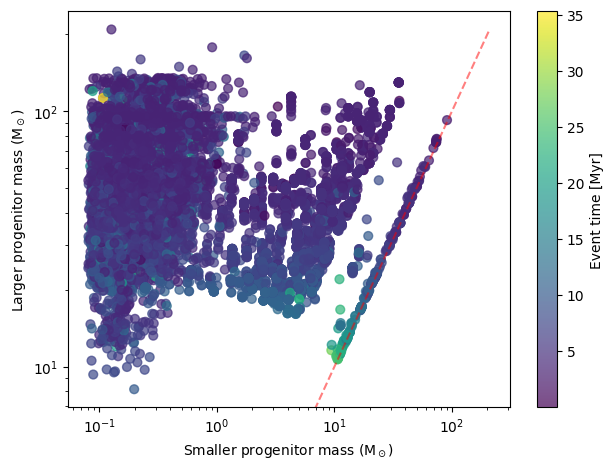

In [20]:
#PLOTTING UNLABELLED mergers
small = np.minimum(ag_merge_bh['m1'], ag_merge_bh['m2'])
large = np.maximum(ag_merge_bh['m1'], ag_merge_bh['m2'])

plt.figure()
sc = plt.scatter(small, large, c=ag_merge_bh['time_x'], cmap='viridis', alpha=.7, s=40)
maxi = large.max(); plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
plt.xlabel('Smaller progenitor mass (M$_\odot$)')
plt.ylabel('Larger progenitor mass (M$_\odot$)')
plt.yscale('log')
plt.xscale('log')

cb = plt.colorbar(sc); cb.set_label('Event time [Myr]')
plt.tight_layout()
plt.show()

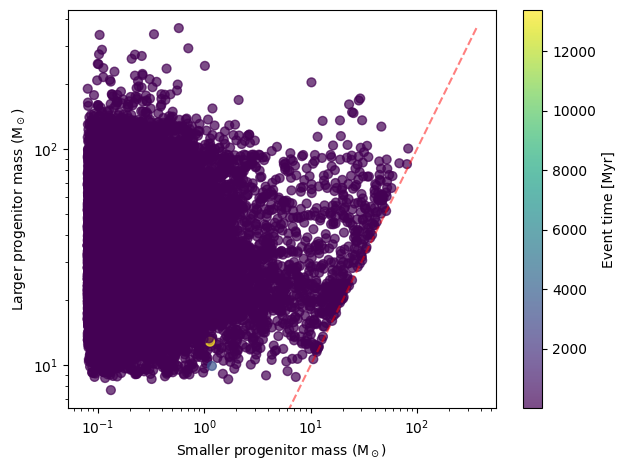

In [21]:
#PLOTTING UNLABELLED COLISIONS
small = np.minimum(ag_col_bh['m1'], ag_col_bh['m2'])
large = np.maximum(ag_col_bh['m1'], ag_col_bh['m2'])

plt.figure()
sc = plt.scatter(small, large, c=ag_col_bh['time_x'], cmap='viridis', alpha=.7, s=40)
maxi = large.max(); plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
plt.xlabel('Smaller progenitor mass (M$_\odot$)')
plt.ylabel('Larger progenitor mass (M$_\odot$)')
plt.yscale('log')
plt.xscale('log')

cb = plt.colorbar(sc); cb.set_label('Event time [Myr]')
plt.tight_layout()
plt.show()

,time,collision_type,idm,mm,id1,m1,id2,m2,r,typem,type1,type2,model
179780,1.139632,binary-single,217674,0.918498,32392,0.692353,205624,0.226145,0.100507,1,1,0,data\N2.0rv0.5rg2.0Z0.0002


# trying k means clustering to find most typical collisions


In [51]:
ag_all_col=ag_col_bh # dont want to mess with my col data
# feature engineering
ag_all_col['smaller_mass'] = ag_all_col[['m1', 'm2']].min(axis=1)
ag_all_col['larger_mass'] = ag_all_col[['m1', 'm2']].max(axis=1)

ag_all_col['mass_ratio'] = ag_all_col['smaller_mass'] / ag_all_col['larger_mass']
ag_all_col['total_mass'] = ag_all_col['smaller_mass'] + ag_all_col['larger_mass']
ag_all_col['mass_difference'] = ag_all_col['larger_mass'] - ag_all_col['smaller_mass']

features = [ 'mass_ratio', 'typem']
X = ag_all_col[features].copy()

X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
#  Test different numbers of clusters using silhouette score
silhouette_scores = []
cluster_range = range(2, 11)  # Test 2 to 10 clusters

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"Optimal number of clusters: {best_n_clusters}")
print(f"Best silhouette score: {best_silhouette:.3f}")

Optimal number of clusters: 4
Best silhouette score: 0.919


In [53]:
# clustering with optimal number
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

#  Add cluster labels 
ag_all_col['collision_cluster'] = cluster_labels

cluster_stats = {}
for cluster_id in ag_all_col['collision_cluster'].unique():
    cluster_data = ag_all_col[ag_all_col['collision_cluster'] == cluster_id]
    
    stats = {
        'count': len(cluster_data),
        'percentage': len(cluster_data) / len(ag_all_col) * 100,
        'mass_characteristics': {
            'avg_smaller_mass': cluster_data['smaller_mass'].mean(),
            'median_smaller_mass': cluster_data['smaller_mass'].median(),
            'median_larger_mass': cluster_data['larger_mass'].median(),
            'avg_larger_mass': cluster_data['larger_mass'].mean(),
            'avg_mass_ratio': cluster_data['mass_ratio'].mean(),
            'avg_total_mass': cluster_data['total_mass'].mean(),
            'avg_merger_mass': cluster_data['mm'].mean()
        },
        'spatial_temporal': {
            'avg_radius': cluster_data['r_x'].mean(),
            'avg_time': cluster_data['time_x'].mean()
        }
    }
    cluster_stats[f'Type_{cluster_id}'] = stats

In [54]:
print(f"\nCollision type distribution:")
for cluster_type, stats in cluster_stats.items():
    print(f"\n{cluster_type}:")
    print(f"  Count: {stats['count']} ({stats['percentage']:.1f}%)")
    print(f"  Avg smaller mass: {stats['mass_characteristics']['avg_smaller_mass']:.2f}")
    print(f"  Avg larger mass: {stats['mass_characteristics']['avg_larger_mass']:.2f}")
    print(f"  Median smaller mass: {stats['mass_characteristics']['median_smaller_mass']:.2f}")
    print(f"  Median larger mass: {stats['mass_characteristics']['median_larger_mass']:.2f}")    
    print(f"  Avg mass ratio: {stats['mass_characteristics']['avg_mass_ratio']:.2f}")
    print(f"  Avg total mass: {stats['mass_characteristics']['avg_total_mass']:.2f}")
    print(f"  Avg merger mass: {stats['mass_characteristics']['avg_merger_mass']:.2f}")
    print(f"  Avg radius: {stats['spatial_temporal']['avg_radius']:.2f}")
    print(f"  Avg time: {stats['spatial_temporal']['avg_time']:.2f}")


Collision type distribution:

Type_3:
  Count: 21729 (85.0%)
  Avg smaller mass: 0.37
  Avg larger mass: 34.53
  Median smaller mass: 0.20
  Median larger mass: 26.31
  Avg mass ratio: 0.01
  Avg total mass: 34.90
  Avg merger mass: 34.08
  Avg radius: 0.22
  Avg time: 7.61

Type_0:
  Count: 441 (1.7%)
  Avg smaller mass: 8.72
  Avg larger mass: 32.08
  Median smaller mass: 5.84
  Median larger mass: 22.93
  Avg mass ratio: 0.26
  Avg total mass: 40.79
  Avg merger mass: 40.30
  Avg radius: 0.21
  Avg time: 6.79

Type_1:
  Count: 3138 (12.3%)
  Avg smaller mass: 0.41
  Avg larger mass: 59.32
  Median smaller mass: 0.20
  Median larger mass: 51.75
  Avg mass ratio: 0.01
  Avg total mass: 59.74
  Avg merger mass: 59.67
  Avg radius: 0.19
  Avg time: 4.59

Type_2:
  Count: 255 (1.0%)
  Avg smaller mass: 23.50
  Avg larger mass: 31.46
  Median smaller mass: 19.09
  Median larger mass: 23.80
  Avg mass ratio: 0.76
  Avg total mass: 54.97
  Avg merger mass: 54.52
  Avg radius: 0.15
  Avg ti

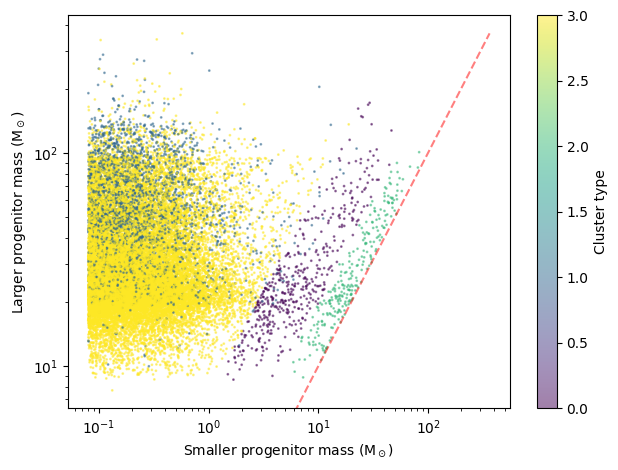

In [56]:
#lets try to color our collisions by labels
small = np.minimum(ag_all_col['m1'], ag_all_col['m2'])
large = np.maximum(ag_all_col['m1'], ag_all_col['m2'])

plt.figure()
sc = plt.scatter(small, large, c=ag_all_col['collision_cluster'], cmap='viridis', alpha=.5, s=1)
maxi = large.max(); plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)

plt.xlabel('Smaller progenitor mass (M$_\odot$)')
plt.ylabel('Larger progenitor mass (M$_\odot$)')
plt.yscale('log')
plt.xscale('log')

cb = plt.colorbar(sc); cb.set_label('Cluster type')
plt.tight_layout()
plt.show()    

# add in lines of mass ratiom

In [28]:
ag_all_col['logm1']=np.log(ag_all_col['m1'])
ag_all_col['logbig']=np.log(ag_all_col['larger_mass'])

ag_all_col.sort_values('logbig').head(40)

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,birth_kick,model,smaller_mass,larger_mass,mass_ratio,total_mass,mass_difference,collision_cluster,logm1,logbig
17719,8.974811,single-single,423817,7.82013,333593,0.132285,423816,7.688810,0.192807,5,...,1.0000,data\N4.0rv0.5rg20.0Z0.02,0.132285,7.68881,0.017205,7.821095,7.556525,0,-2.022797,2.039766
5313,9.035058,binary-single,1719249,10.31810,114282,1.683080,1719248,8.635000,0.170827,5,...,0.0000,data\N16rv0.5rg20.0Z0.02,1.683080,8.63500,0.194914,10.318080,6.951920,0,0.520625,2.155824
1861,8.252619,single-single,1685710,8.97000,1685709,8.656100,253835,0.319945,0.065570,4,...,630.9921,data\N16rv0.5rg2.0Z0.02,0.319945,8.65610,0.036962,8.976045,8.336155,0,2.158264,2.158264
6303,7.983067,single-single,2357573,8.86052,1037065,8.745980,677573,0.116767,0.301304,4,...,1.0000,data\N16rv0.5rg20.0Z0.02,0.116767,8.74598,0.013351,8.862747,8.629213,0,2.168594,2.168594
6258,7.910337,single-single,2272098,15.85330,829157,7.267830,592098,8.846520,0.368354,4,...,1.0000,data\N16rv0.5rg20.0Z0.02,7.267830,8.84652,0.821547,16.114350,1.578690,2,1.983458,2.180024
24306,18.187226,single-single,1259770,8.94100,815803,8.849720,419770,0.092919,0.084202,4,...,893.1551,data\N8.0rv0.5rg8.0Z0.02,0.092919,8.84972,0.010500,8.942639,8.756801,0,2.180386,2.180386
20454,8.146019,single-single,887059,9.04145,83813,8.892380,47059,0.151514,0.056180,4,...,207.0781,data\N8.0rv0.5rg2.0Z0.02,0.151514,8.89238,0.017039,9.043894,8.740866,0,2.185195,2.185195
17044,8.210363,single-single,525592,9.32794,105592,0.426833,212127,8.906790,0.392742,4,...,1.0000,data\N4.0rv0.5rg2.0Z0.02,0.426833,8.90679,0.047922,9.333623,8.479957,0,-0.851362,2.186814
20503,7.834343,single-single,903470,9.07585,477888,0.138561,63470,8.939850,0.130737,4,...,1.0000,data\N8.0rv0.5rg2.0Z0.02,0.138561,8.93985,0.015499,9.078411,8.801289,0,-1.976445,2.190519
6017,8.372182,single-single,1997111,12.76950,393210,3.817140,317111,8.992080,0.313184,4,...,1.0000,data\N16rv0.5rg20.0Z0.02,3.817140,8.99208,0.424500,12.809220,5.174940,2,1.339501,2.196344


# trying another clustering method


## Fairly useless as this gives us 23 clusters

In [29]:
import hdbscan
import numpy as np

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
collision_types = clusterer.fit_predict(X_scaled)

# Add to your dataframe
ag_all_col['collision_type_hdbscan'] = collision_types

# Analyze cluster stability
cluster_persistence = clusterer.cluster_persistence_
cluster_persistence

array([3.86320617e-03, 1.13366145e-03, 5.18302443e-03, 6.14890965e-03,
       4.07558888e-02, 1.34967997e-03, 3.64610646e-02, 1.26278268e-03,
       1.59196753e-03, 2.54412626e-04, 1.56188790e-03, 2.46371447e-05,
       1.18312221e-03, 6.97436404e-04, 2.72676277e-04, 5.51022713e-03,
       4.22669437e-03, 3.09223777e-03, 6.00778957e-03, 2.64665116e-03,
       2.22460742e-02, 7.22537739e-03, 1.43444861e-02, 1.41668392e-02,
       3.47633373e-03, 1.17606953e-02, 1.57180744e-04, 2.76715449e-02,
       4.92422078e-03, 1.11912170e-04, 1.04058508e-02, 1.15117686e-02,
       5.05799381e-03, 1.05942244e-02, 8.93731058e-03, 5.69867842e-03,
       9.60858370e-03, 1.89018243e-02, 2.48807622e-03, 2.09575649e-02,
       1.26939811e-02, 7.85943110e-03, 0.00000000e+00, 1.12166389e-02,
       5.85871351e-03, 1.39721827e-02, 4.20602777e-02, 5.55143421e-02,
       8.18233971e-03, 5.81021497e-02, 2.75174475e-02, 3.14691323e-02,
       6.53444692e-02, 5.57206437e-02, 5.75822218e-02, 4.54889491e-02,
      

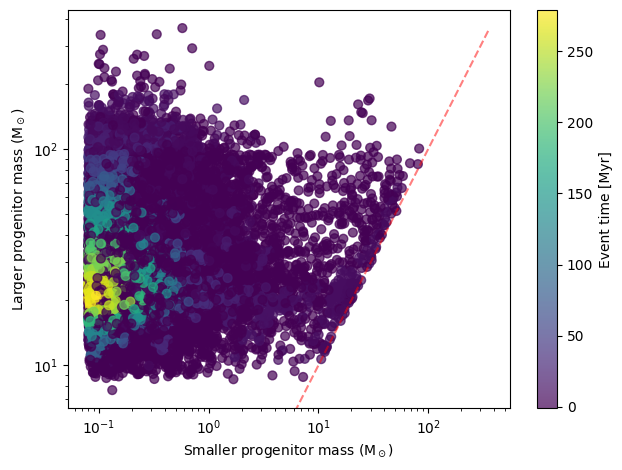

In [30]:
#lets try to color our collisions by labels (HBDSCAN CLUSTERING)
small = np.minimum(ag_all_col['m1'], ag_all_col['m2'])
large = np.maximum(ag_all_col['m1'], ag_all_col['m2'])

plt.figure()
sc = plt.scatter(small, large, c=ag_all_col['collision_type_hdbscan'], cmap='viridis', alpha=.7, s=40)
maxi = large.max(); plt.plot([0,maxi],[0,maxi],'r--',alpha=.5)
plt.xlabel('Smaller progenitor mass (M$_\odot$)')
plt.ylabel('Larger progenitor mass (M$_\odot$)')
plt.yscale('log')
plt.xscale('log')

cb = plt.colorbar(sc); cb.set_label('Event time [Myr]')
plt.tight_layout()
plt.show()    

# analyzing col and merge bh

In [31]:
def format_cluster_stats(cluster_stats, cluster_name):
    stats = cluster_stats[cluster_name]
    
    formatted_text = f"""
{cluster_name}:
Count: {stats['count']} ({stats['percentage']:.1f}%)
Avg Smaller Mass: {stats['mass_characteristics']['avg_smaller_mass']:.2f} M☉
Avg Larger Mass: {stats['mass_characteristics']['avg_larger_mass']:.2f} M☉
Median Smaller Mass: {stats['mass_characteristics']['median_smaller_mass']:.2f} M☉
Median Larger Mass: {stats['mass_characteristics']['median_larger_mass']:.2f} M☉
Avg Mass Ratio: {stats['mass_characteristics']['avg_mass_ratio']:.2f}
Avg Total Mass: {stats['mass_characteristics']['avg_total_mass']:.2f} M☉
Avg Merger Mass: {stats['mass_characteristics']['avg_merger_mass']:.2f} M☉
Avg Radius: {stats['spatial_temporal']['avg_radius']:.2f} pc
Avg Time: {stats['spatial_temporal']['avg_time']:.2f} Myr
    """.strip()
    
    return formatted_text

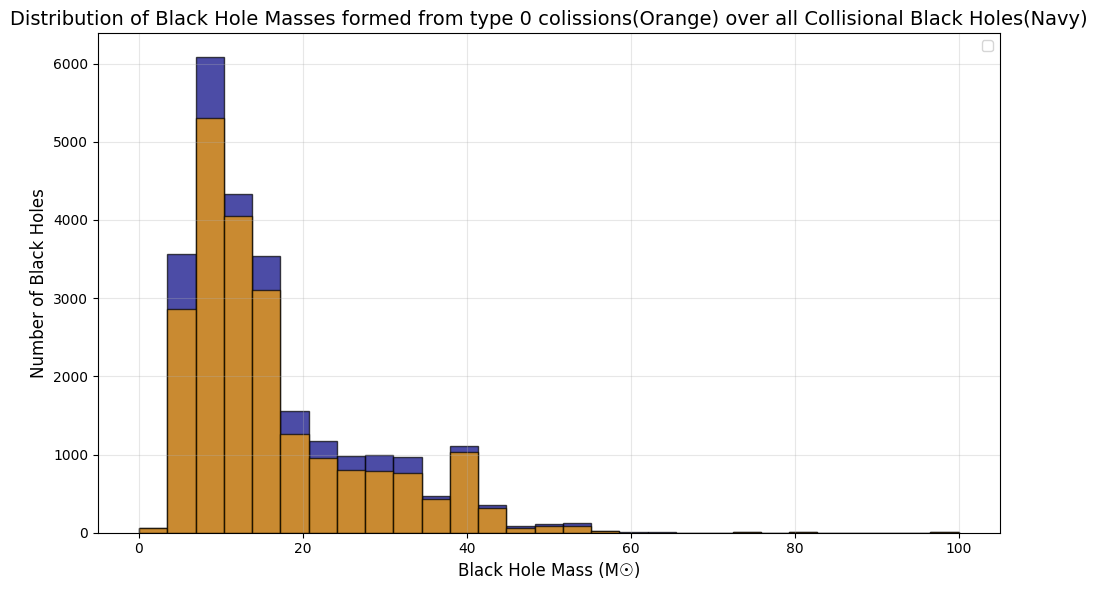

Type_0:
Count: 21996 (86.0%)
Avg Smaller Mass: 0.45 M☉
Avg Larger Mass: 34.11 M☉
Median Smaller Mass: 0.21 M☉
Median Larger Mass: 26.18 M☉
Avg Mass Ratio: 0.02
Avg Total Mass: 34.57 M☉
Avg Merger Mass: 33.78 M☉
Avg Radius: 0.22 pc
Avg Time: 7.61 Myr


In [32]:
# Create a histogram of black hole masses fromed from colisions w/ types
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
plt.hist(ag_all_col['bh_mass'], bins=bins, color='navy', alpha=0.7, edgecolor='black')
plt.xlabel('Black Hole Mass (M☉)', fontsize=12)
plt.ylabel('Number of Black Holes', fontsize=12)
plt.title('Distribution of Black Hole Masses formed from type 0 colissions(Orange) over all Collisional Black Holes(Navy)', fontsize=14)
col_bh_0= ag_all_col[ag_all_col['collision_cluster'] == 0]
bins2 = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
plt.hist(col_bh_0['bh_mass'], bins=bins2, color='orange', alpha=0.7, edgecolor='black')
plt.grid(alpha=0.3)

format_cluster_stats(cluster_stats, 'Type_0')

plt.tight_layout()
plt.legend()
plt.show()
print(format_cluster_stats(cluster_stats, 'Type_0'))


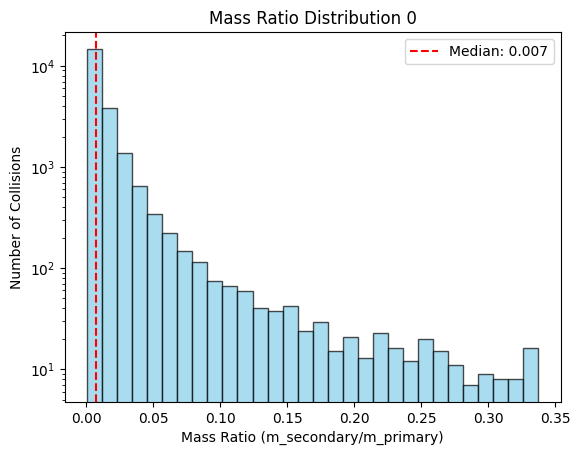

In [33]:
plt.hist(col_bh_0['mass_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Mass Ratio (m_secondary/m_primary)')
plt.ylabel('Number of Collisions')
plt.title('Mass Ratio Distribution 0')
plt.axvline(col_bh_0['mass_ratio'].median(), color='red', linestyle='--', 
        label=f'Median: {col_bh_0["mass_ratio"].median():.3f}')
plt.legend()
plt.yscale('log')

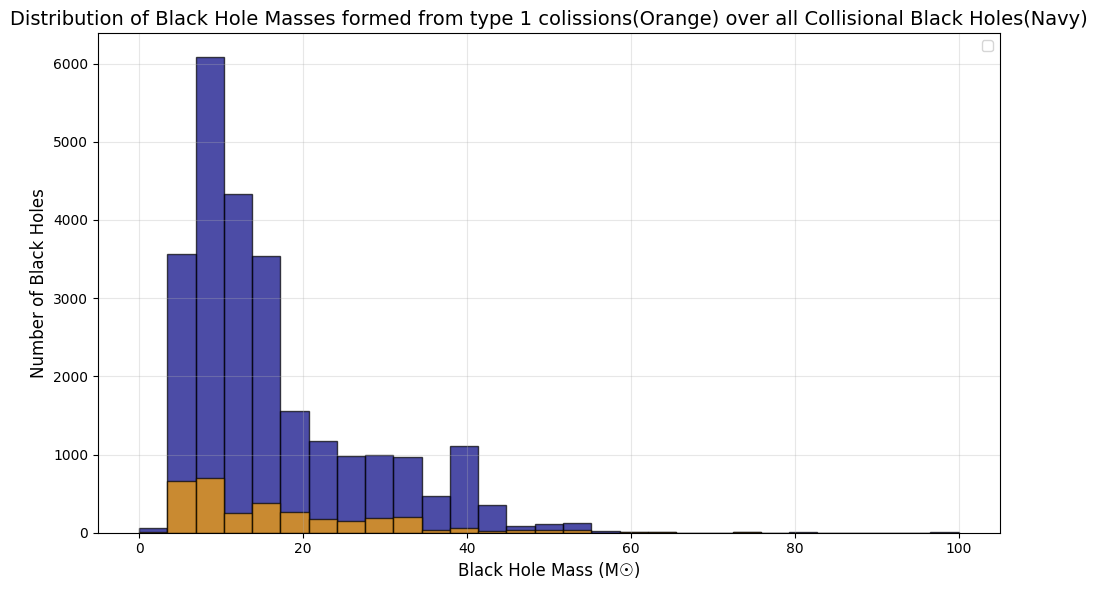

Type_1:
Count: 3209 (12.6%)
Avg Smaller Mass: 0.52 M☉
Avg Larger Mass: 61.35 M☉
Median Smaller Mass: 0.20 M☉
Median Larger Mass: 52.15 M☉
Avg Mass Ratio: 0.01
Avg Total Mass: 61.87 M☉
Avg Merger Mass: 61.54 M☉
Avg Radius: 0.18 pc
Avg Time: 4.63 Myr


In [34]:
# Create a histogram of black hole masses fromed from colisions w/ types
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
plt.hist(ag_all_col['bh_mass'], bins=bins, color='navy', alpha=0.7, edgecolor='black')
plt.xlabel('Black Hole Mass (M☉)', fontsize=12)
plt.ylabel('Number of Black Holes', fontsize=12)
plt.title('Distribution of Black Hole Masses formed from type 1 colissions(Orange) over all Collisional Black Holes(Navy)', fontsize=14)
col_bh_1= ag_all_col[ag_all_col['collision_cluster'] == 1]
bins2 = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
plt.hist(col_bh_1['bh_mass'], bins=bins2, color='orange', alpha=0.7, edgecolor='black')
plt.grid(alpha=0.3)

format_cluster_stats(cluster_stats, 'Type_1')

plt.tight_layout()
plt.legend()
plt.show()
print(format_cluster_stats(cluster_stats, 'Type_1'))

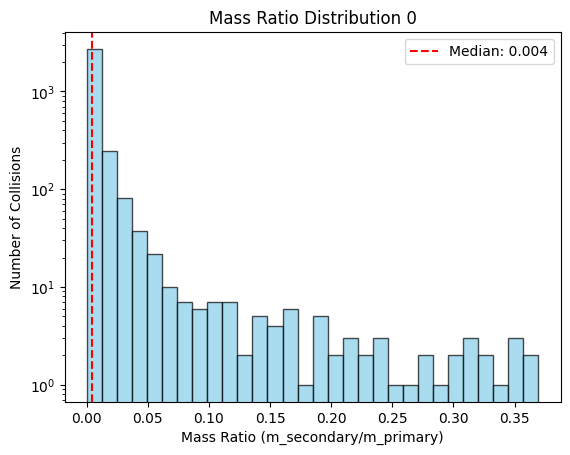

In [35]:
plt.hist(col_bh_1['mass_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Mass Ratio (m_secondary/m_primary)')
plt.ylabel('Number of Collisions')
plt.title('Mass Ratio Distribution 0')
plt.axvline(col_bh_1['mass_ratio'].median(), color='red', linestyle='--', 
        label=f'Median: {col_bh_1["mass_ratio"].median():.3f}')
plt.legend()
plt.yscale('log')

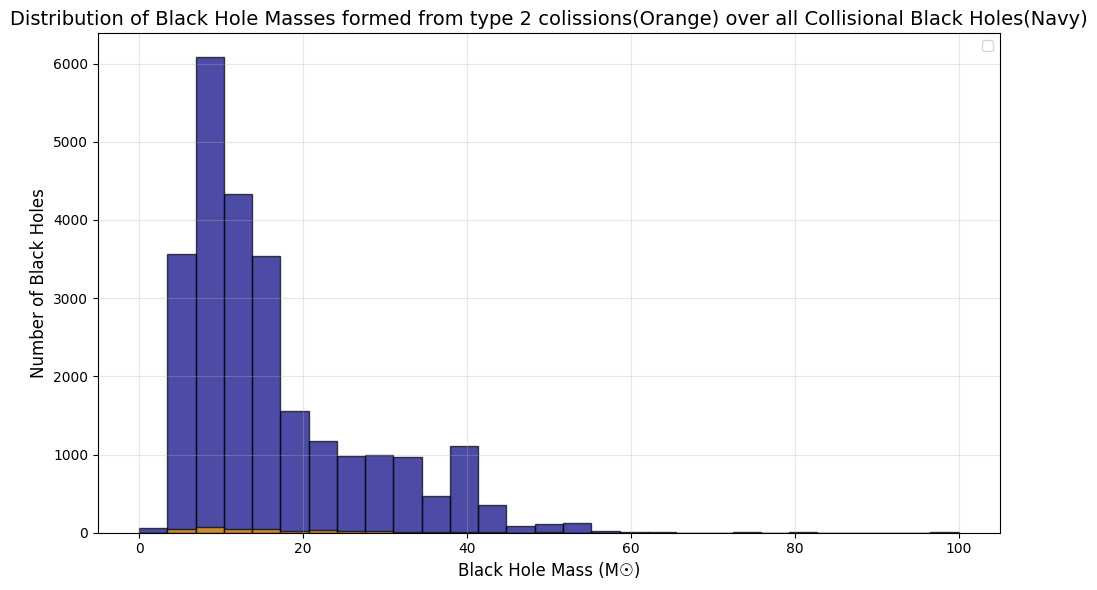

Type_2:
Count: 358 (1.4%)
Avg Smaller Mass: 20.77 M☉
Avg Larger Mass: 32.10 M☉
Median Smaller Mass: 16.64 M☉
Median Larger Mass: 23.94 M☉
Avg Mass Ratio: 0.66
Avg Total Mass: 52.87 M☉
Avg Merger Mass: 52.47 M☉
Avg Radius: 0.16 pc
Avg Time: 6.92 Myr


In [36]:
# Create a histogram of black hole masses fromed from colisions w/ types
plt.figure(figsize=(10, 6))
bins = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
plt.hist(ag_all_col['bh_mass'], bins=bins, color='navy', alpha=0.7, edgecolor='black')
plt.xlabel('Black Hole Mass (M☉)', fontsize=12)
plt.ylabel('Number of Black Holes', fontsize=12)
plt.title('Distribution of Black Hole Masses formed from type 2 colissions(Orange) over all Collisional Black Holes(Navy)', fontsize=14)
col_bh_2= ag_all_col[ag_all_col['collision_cluster'] == 2]
bins2 = np.linspace(0, 100, 30)  # Create bins upto 100 m sun
plt.hist(col_bh_2['bh_mass'], bins=bins2, color='orange', alpha=0.7, edgecolor='black')
plt.grid(alpha=0.3)

format_cluster_stats(cluster_stats, 'Type_2')

plt.tight_layout()
plt.legend()
plt.show()
print(format_cluster_stats(cluster_stats, 'Type_2'))

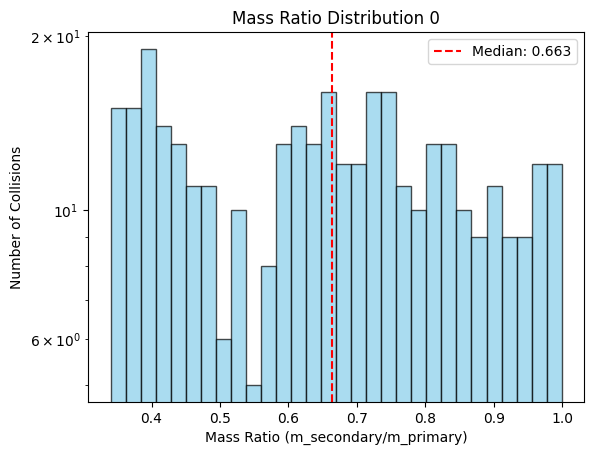

In [37]:
plt.hist(col_bh_2['mass_ratio'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Mass Ratio (m_secondary/m_primary)')
plt.ylabel('Number of Collisions')
plt.title('Mass Ratio Distribution 0')
plt.axvline(col_bh_2['mass_ratio'].median(), color='red', linestyle='--', 
        label=f'Median: {col_bh_2["mass_ratio"].median():.3f}')
plt.legend()
plt.yscale('log')

In [38]:
col_bh_3 = ag_all_col[ag_all_col['collision_type']==3]

In [39]:
col_bh_3

,time_x,collision_type,idm,mm,id1,m1,id2,m2,r_x,typem,...,model,smaller_mass,larger_mass,mass_ratio,total_mass,mass_difference,collision_cluster,logm1,logbig,collision_type_hdbscan


In [40]:
ag_all_col[ag_all_col['birth_kick']!=0].sort_values('birth_kick',ascending=False).shape[0] / ag_all_col.shape[0]

0.8789656926025897